In [76]:
# Tensorflow / Keras
import tensorflow as tf
from tensorflow import keras 
from keras.models import Sequential # creating a linear stack of NN
from keras import Input # for instantiating a keras tensor
from keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout 

# data manipulation
import pandas as pd
import numpy as np

# sklearn 
import sklearn 
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.preprocessing import OrdinalEncoder

# visualisation 
import cv2 
import matplotlib
import matplotlib.pyplot as plt



In [77]:
import sys
import os

# assigning main directory path to a variable
main_dir = os.path.dirname(sys.path[0])
print(main_dir)

d:\Coding


In [78]:
# location prefix of images
IMG_LOCATION = main_dir + "\\Caltech-101-CNN\\data\\101_ObjectCategories\\"

#categories we are interested in 
LABELS = set(['dalmatian','hedgehog','llama', 'panda'])

# create two lists to contain image paths and image labels
ImagePaths = []
ListLabels = []
for label in LABELS:
    for image in list(os.listdir(IMG_LOCATION + label)):
        ImagePaths = ImagePaths + [IMG_LOCATION + label + "/" + image]
        ListLabels = ListLabels + [label]

# load images and resizing them
data = []
for img in ImagePaths:
    image = cv2.imread(img)
    image = cv2.resize(image, (128,128))
    data.append(image)

# convert image data to numpy array and standardize values 
data = np.array(data, dtype = "float") / 255

The shape of data is 4 dimensional `(237, 128, 128, 3)`
- 237 : objects/images
- 128 : pixels along x axis
- 128 : pixels along y axis
- 3 : the colours R, G, B channels

That is `Sample, rows, columns, channels`

In [79]:
data.shape

(237, 128, 128, 3)

Our target will be one of the four values - 
- llama
- panda
- dalmatian
- hedgehog
so we create a np array and encode it too!

In [80]:
# also converting labels list to np array 
LablesArray = np.array(ListLabels)

# Encode labels 
enc = OrdinalEncoder()
y = enc.fit_transform(LablesArray.reshape(-1,1))

Now we need to create training and testing samples using sklearn!


In [81]:
X_train, X_test, y_train, y_test = train_test_split(data,y, test_size = 0.2, random_state= 42)

# Print shapes
print("Shape of X_train: ", X_train.shape)
print("Shape of y_train: ", y_train.shape)
print("Shape of X_test: ", X_test.shape)
print("Shape of y_test: ", y_test.shape)

Shape of X_train:  (189, 128, 128, 3)
Shape of y_train:  (189, 1)
Shape of X_test:  (48, 128, 128, 3)
Shape of y_test:  (48, 1)


let us display some of the images in our dataset

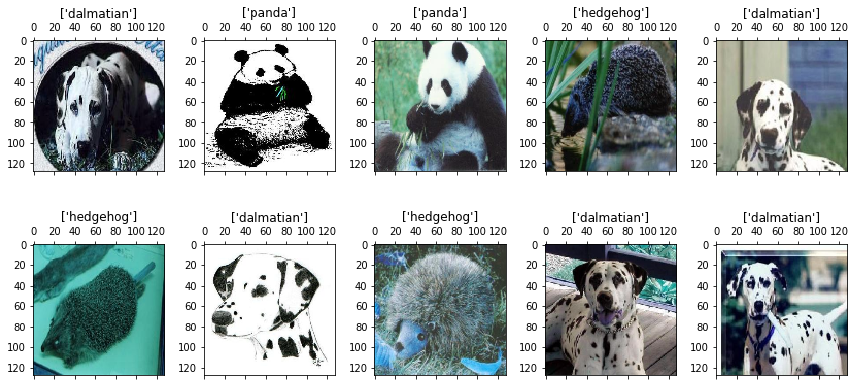

In [82]:
fig, axs = plt.subplots(2, 5, sharey= False, tight_layout = True, figsize = (12,6), facecolor = 'white')
n = 0
for i in range(0,2):
    for j in range(0, 5):
        axs[i,j].matshow(X_train[n])
        axs[i,j].set(title = enc.inverse_transform(y_train)[n])
        n += 1
plt.show()

## Training and Evaluating Deep Convolutional Network 
Some points to understand 
- initial Convolutional layers help extract the low-level features, like horizontal, vertical lines, while the later one extract high level details (eye, nose etc.)
- Structure of DCN model:
    - Input Layer
    - The first set of Conv., Max Pooling, Dropout Layer
    - The second, third set
    - Flattening the layer
    - Dense Hidden Layer
    - Output layer 
         
Here the purpose of Dropout layer is to set random amount of inputs as zero so as to avoid overfitting!

### Step 1 - Specifying the Structure of Neural Network

In [83]:
## define a model
from itertools import dropwhile


model = Sequential(name= "DCN-Model")

# input layer
# specifying the shape 
model.add(Input(
    shape=(X_train.shape[1], X_train.shape[2], X_train.shape[3]),
    name = "Input-Layer"))

# First set of Conv, MaxPooling, Dropout Layer
model.add(Conv2D(
    filters = 16,
    kernel_size = (3,3),
    strides = (1,1),
    padding='valid',
    data_format = None, 
    dilation_rate = (1,1),
    groups = 1,
    activation = 'relu',
    use_bias = True,
    kernel_initializer='glorot_uniform',
    bias_initializer="zeros",
    kernel_regularizer = None, 
    bias_regularizer=None,
    activity_regularizer=None, 
    kernel_constraint= None,
    bias_constraint=None,
    name= '2D-Convolutional-Layer-1'
))

model.add(MaxPool2D(pool_size=(2,2),
strides=(2,2),
padding= 'valid',
data_format=None,
name='2D-MaxPool_layer-1'))

model.add(Dropout(0.2, name="Dropout-Layer-1"))

#--- second set of convolution, max pooling and droput layer
model.add(Conv2D(filters= 64, kernel_size= (3,3), strides=(1,1), padding='valid', activation='relu', name='2D-Convolution-Layer'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2), padding = 'valid', name = "2D-Max-Pool"))
model.add(Dropout(0.2, name="Dropout-Layer-2"))

# --- Third set of the same
model.add(Conv2D(filters = 64, kernel_size = (3,3), strides = (1,1), padding = 'same', activation= 'relu', name = '2D-Convolutional-Layer-3'))
model.add(MaxPool2D(pool_size = (2,2), strides = (2,2), padding = 'same', name = '2D-MaxPooling-Layer'))
model.add(Dropout(0.2, name= "Dropout-Layer-3"))